In [1]:
import numpy as np
import matplotlib.pyplot as plt

#import os
#os.environ['pRT_input_data_path'] = '/home/sdregt/new_retrieval_venv/pRT_input_data'
#os.environ['LD_LIBRARY_PATH'] = '/home/sdregt/new_retrieval_venv/MultiNest/lib'

from retrieval_base.rotation_profile import IntRotationProfile

import matplotlib as mpl

In [2]:
import retrieval_base.auxiliary_functions as af
import copy

import pymultinest
import json

def read_results(prefix, n_params, m_set='K2166_A', w_set='K2166'):

    # Set-up analyzer object
    analyzer = pymultinest.Analyzer(
        n_params=n_params, 
        outputfiles_basename=prefix
        )
    stats = analyzer.get_stats()

    # Load the equally-weighted posterior distribution
    posterior = analyzer.get_equal_weighted_posterior()
    posterior = posterior[:,:-1]

    # Read the parameters of the best-fitting model
    bestfit = np.array(stats['modes'][0]['maximum a posterior'])

    PT = af.pickle_load(prefix+f'data/bestfit_PT_{m_set}.pkl')
    Chem = af.pickle_load(prefix+f'data/bestfit_Chem_{m_set}.pkl')

    m_spec = af.pickle_load(prefix+f'data/bestfit_m_spec_{m_set}.pkl')
    d_spec = af.pickle_load(prefix+f'data/d_spec_{w_set}.pkl')

    LogLike = af.pickle_load(prefix+f'data/bestfit_LogLike_{m_set}.pkl')

    try:
        Cov = af.pickle_load(prefix+f'data/bestfit_Cov_{m_set}.pkl')
    except:
        Cov = None

    int_contr_em           = np.load(prefix+f'data/bestfit_int_contr_em_{m_set}.npy')
    int_contr_em_per_order = np.load(prefix+f'data/bestfit_int_contr_em_per_order_{m_set}.npy')
    int_opa_cloud          = np.load(prefix+f'data/bestfit_int_opa_cloud_{m_set}.npy')

    f = open(prefix+'data/bestfit.json')
    bestfit_params = json.load(f)
    f.close()

    return posterior, bestfit, PT, Chem, int_contr_em, int_contr_em_per_order, int_opa_cloud, m_spec, d_spec, LogLike, Cov, bestfit_params

prefix_no_band = './retrieval_outputs/no_bands_K_B_ret_4/test_'
res = read_results(prefix=prefix_no_band, n_params=26)
_, _, PT_no_band, Chem_no_band, _, _, _, m_spec_no_band, d_spec_no_band, _, _, bestfit_params_no_band = res
del res

prefix_eq_band = './retrieval_outputs/eq_band_K_B_ret_1/test_'
res = read_results(prefix=prefix_eq_band, n_params=28)
_, _, PT_eq_band, Chem_eq_band, _, _, _, m_spec_eq_band, d_spec_eq_band, _, _, bestfit_params_eq_band = res
del res

  analysing data from ./retrieval_outputs/no_bands_K_B_ret_4/test_.txt
  analysing data from ./retrieval_outputs/eq_band_K_B_ret_1/test_.txt


In [3]:
def get_pRT_atm(prefix, bestfit_params, Chem, PT, m_set='K2166_A', vsini_local=0, line_species=None):

    pRT_atm = af.pickle_load(f'{prefix}data/pRT_atm_broad_{m_set}.pkl')

    # Compute global model spectrum
    params_global = copy.deepcopy(bestfit_params['params'][m_set])
    if prefix.endswith('no_bands_K_B_ret_4/test_'):
        params_global['lat_band'] = None
    pRT_atm.params = params_global

    m_spec_global = pRT_atm(Chem.mass_fractions, PT.temperature, params_global, get_contr=False, get_full_spectrum=True)
    m_spec_global.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_global.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    Rot = copy.copy(pRT_atm.Rot)

    # Compute local model spectrum
    params_local = copy.deepcopy(params_global)
    params_local['vsini'] = vsini_local
    params_local['lat_band'] = None
    params_local['lat_band_upper'] = 90
    params_local['epsilon_band'] = 1
    pRT_atm.params = params_local

    # Local abundances
    mf_local = Chem.mass_fractions.copy()
    if line_species is not None:
        
        for key_i in mf_local.keys():
            # Set abundances of other species to 0
            if key_i != line_species:
                mf_local[key_i] *= 0

    m_spec_local = pRT_atm(mf_local, PT.temperature, params_local, get_contr=False, get_full_spectrum=True)
    m_spec_local.wave_pRT_grid = copy.copy(pRT_atm.wave_pRT_grid)
    m_spec_local.flux_pRT_grid = copy.copy(pRT_atm.flux_pRT_grid)

    return m_spec_global, m_spec_local, Rot

m_spec_global_no_band, m_spec_local_no_band, Rot_no_band = get_pRT_atm(
    prefix_no_band, bestfit_params_no_band, copy.deepcopy(Chem_no_band), PT_no_band
    #prefix_no_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band
    )
m_spec_global_eq_band, m_spec_local_eq_band, Rot_eq_band = get_pRT_atm(
    prefix_eq_band, bestfit_params_eq_band, copy.deepcopy(Chem_eq_band), PT_eq_band
    )

In [4]:
'''
Rot_no_band.f_grid = Rot_no_band.get_f_grid(bestfit_params_no_band['params']['K2166_A'])
Rot_no_band.f_grid /= np.sum(Rot_no_band.f_grid * Rot_no_band.area_per_segment)
Rot_eq_band.f_grid = Rot_eq_band.get_f_grid(bestfit_params_eq_band['params']['K2166_A'])
Rot_eq_band.f_grid /= np.sum(Rot_eq_band.f_grid * Rot_eq_band.area_per_segment)

print(Rot_no_band.f_grid.min(), Rot_no_band.f_grid.max())
print(Rot_eq_band.f_grid.min(), Rot_eq_band.f_grid.max())

# Compute velocity-grid
vsini = bestfit_params_no_band['params']['K2166_A'].get('vsini', 0)
Rot_no_band.v_grid = vsini * Rot_no_band.r_grid * np.sin(Rot_no_band.theta_grid)

vsini = bestfit_params_eq_band['params']['K2166_A'].get('vsini', 0)
Rot_eq_band.v_grid = vsini * Rot_eq_band.r_grid * np.sin(Rot_eq_band.theta_grid)
'''

"\nRot_no_band.f_grid = Rot_no_band.get_f_grid(bestfit_params_no_band['params']['K2166_A'])\nRot_no_band.f_grid /= np.sum(Rot_no_band.f_grid * Rot_no_band.area_per_segment)\nRot_eq_band.f_grid = Rot_eq_band.get_f_grid(bestfit_params_eq_band['params']['K2166_A'])\nRot_eq_band.f_grid /= np.sum(Rot_eq_band.f_grid * Rot_eq_band.area_per_segment)\n\nprint(Rot_no_band.f_grid.min(), Rot_no_band.f_grid.max())\nprint(Rot_eq_band.f_grid.min(), Rot_eq_band.f_grid.max())\n\n# Compute velocity-grid\nvsini = bestfit_params_no_band['params']['K2166_A'].get('vsini', 0)\nRot_no_band.v_grid = vsini * Rot_no_band.r_grid * np.sin(Rot_no_band.theta_grid)\n\nvsini = bestfit_params_eq_band['params']['K2166_A'].get('vsini', 0)\nRot_eq_band.v_grid = vsini * Rot_eq_band.r_grid * np.sin(Rot_eq_band.theta_grid)\n"

In [5]:
def orthographic_to_xy(lat, lon, lat_0, lon_0, R=1):

    x = R * np.cos(lat) * np.sin(lon-lon_0)
    y = R * (np.cos(lat_0)*np.sin(lat) - np.sin(lat_0)*np.cos(lat)*np.cos(lon-lon_0))

    c = np.arccos(
        np.sin(lat_0)*np.sin(lat) + np.cos(lat_0)*np.cos(lat)*np.cos(lon-lon_0)
    )

    mask = (c > -np.pi/2) & (c < np.pi/2)
    x[~mask] = np.nan
    y[~mask] = np.nan
    return x, y, c

def plot_grid(ax, lat_grid=np.arange(-90,90+1e-6,30), lon_grid=np.arange(0,360,30), inclination=26, lat_band=None, lon_0=0, **kwargs):

    lat = np.deg2rad(np.linspace(-90,90,100))
    lon = np.deg2rad(np.linspace(0,360,100))

    inclination = np.deg2rad(inclination)
    lon_0 = np.deg2rad(lon_0)

    for lat_i in np.deg2rad(lat_grid):

        # Orthographic projection
        x, y, c = orthographic_to_xy(lat_i, lon, inclination, lon_0)

        # Convert to polar coordinates
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)

        ax.plot(phi, r, **kwargs)

    for lon_i in np.deg2rad(lon_grid):
        
        # Orthographic projection
        x, y, c = orthographic_to_xy(lat, lon_i, inclination, lon_0)

        # Convert to polar coordinates
        r = np.sqrt(x**2 + y**2)
        phi = np.arctan2(y,x)

        ax.plot(phi, r, **kwargs)

    if lat_band is not None:
        for pm in [-1,+1]:
            # Orthographic projection
            x, y, c = orthographic_to_xy(pm*np.deg2rad(lat_band), lon+np.pi, inclination, lon_0)

            # Convert to polar coordinates
            r = np.sqrt(x**2 + y**2)
            phi = np.arctan2(y,x)

            ax.plot(phi, r, c='k', lw=2, ls=(0,(5,5)))

def plot_map(ax, attr, Rot, cax=None, **kwargs):

    z = getattr(Rot, attr)

    for i, r_i in enumerate(Rot.unique_r):
        th_i = Rot.theta_grid[Rot.r_grid==r_i]
        z_i  = z[Rot.r_grid==r_i]
        r_i  = np.array([r_i])

        th_i = np.concatenate((th_i-th_i.min(), [2*np.pi]))

        r_i = np.array([
            np.sin(Rot.unique_c[i] - (np.pi/2)/Rot.n_c/2), 
            np.sin(Rot.unique_c[i] + (np.pi/2)/Rot.n_c/2)*2, 
            ])

        zz_shape = (len(r_i)-1,len(th_i)-1)

        tt, rr = np.meshgrid(th_i, r_i)
        zz = z_i.reshape(zz_shape)

        #ax.plot(0, Rot.unique_r[i], 'k.')
        cntr = ax.pcolormesh(np.pi/2-tt, rr, zz, shading='auto', **kwargs)

    if cax is not None:
        import matplotlib as mpl

        norm = mpl.colors.Normalize(vmin=kwargs.get('vmin'), vmax=kwargs.get('vmax'))
        plt.colorbar(
            mpl.cm.ScalarMappable(norm=norm, cmap=kwargs.get('cmap')), 
            ax=ax, cax=cax, orientation='vertical'
            )

In [6]:
print(bestfit_params_no_band['params']['K2166_A']['vsini'])
print(bestfit_params_eq_band['params']['K2166_A']['vsini'])

29.295173200397993
25.209022260524783


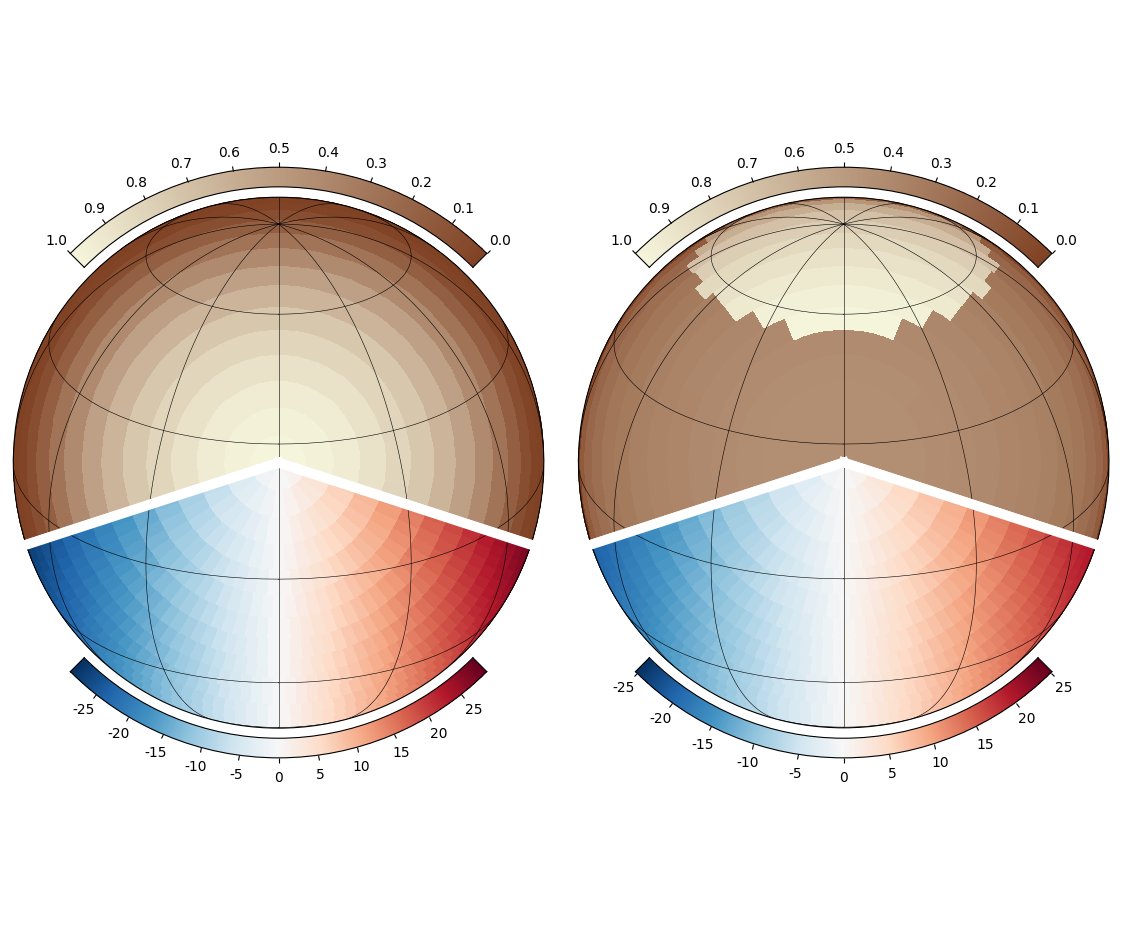

In [22]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', ['k','sienna'])
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [cmap(0.8),'beige'])

fig = plt.figure(figsize=(14,7))
gs = fig.add_gridspec(nrows=1, ncols=2, hspace=0, wspace=0.02)#, height_ratios=[0.1,0.8,0.1])
wspace = gs.wspace

ax  = np.array([
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    ])

cax = np.array([
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,0],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    fig.add_subplot(gs[0,1],projection='polar'),
    ])

vmin, vmax = Rot_no_band.f_grid.min(), Rot_no_band.f_grid.max()
#vmin, vmax = 0, 1
plot_map(ax[0], 'f_grid', Rot_no_band, cmap=cmap, vmin=vmin, vmax=vmax)

#vmin, vmax = Rot_no_band.v_grid.min(), Rot_no_band.v_grid.max()
vmax = bestfit_params_no_band['params']['K2166_A']['vsini']
vmin = -vmax
plot_map(ax[1], 'v_grid', Rot_no_band, cmap='RdBu_r', vmin=vmin, vmax=vmax)

vmin, vmax = Rot_eq_band.f_grid.min(), Rot_eq_band.f_grid.max()
#vmin, vmax = 0, 1
plot_map(ax[2], 'f_grid', Rot_eq_band, cmap=cmap, vmin=vmin, vmax=vmax)

#vmin, vmax = Rot_eq_band.v_grid.min(), Rot_eq_band.v_grid.max()
#vmax = bestfit_params_eq_band['params']['K2166_A']['vsini']
vmax = bestfit_params_no_band['params']['K2166_A']['vsini']
vmin = -vmax
plot_map(ax[3], 'v_grid', Rot_eq_band, cmap='RdBu_r', vmin=vmin, vmax=vmax)

for i, ax_i in enumerate(ax.flatten()):
    ax_i.grid(False)
    ax_i.set_xticks([])
    ax_i.set_yticks([])
    ax_i.set_ylim(0,1)

    inc   = np.rad2deg([Rot_no_band,Rot_no_band,Rot_eq_band,Rot_eq_band][i].inc)
    lon_0 = np.rad2deg([Rot_no_band,Rot_no_band,Rot_eq_band,Rot_eq_band][i].lon_0)
    lat_band = [
        bestfit_params_no_band,bestfit_params_no_band,bestfit_params_eq_band,bestfit_params_eq_band
        ][i]['params']['K2166_A'].get('lat_band')
    lat_band = None

    plot_grid(ax_i, inclination=inc, lon_0=lon_0, c='k', alpha=1, lw=0.4, lat_band=lat_band)

    #[spine_i.set_linewidth(2) for spine_i in ax_i.spines.values()]
    #[spine_i.set_color('w') for spine_i in ax_i.spines.values()]

    for key_i in ['start', 'end']:
        ax_i.spines[key_i].set_linewidth(7)
        ax_i.spines[key_i].set_color('w')
        #ax_i.spines[key_i].set_color('k')

#for key_i in ['start', 'end']:
#    ax[1].spines[key_i].set_linewidth(3)
#    ax[3].spines[key_i].set_linewidth(3)
#
#    ax[1].spines[key_i].set_color('w')
#    ax[3].spines[key_i].set_color('w')

def set_thetalim(ax, theta_cen, theta_width):
    ax.set_thetalim(theta_cen-theta_width/2, theta_cen+theta_width/2)

set_thetalim(ax[0], 1/2*np.pi, 1.2*np.pi)
set_thetalim(ax[1], -1/2*np.pi, (2-1.2)*np.pi)

set_thetalim(ax[2], 1/2*np.pi, 1.2*np.pi)
set_thetalim(ax[3], -1/2*np.pi, (2-1.2)*np.pi)
#set_thetalim(ax[2], 1/2*np.pi, 3/2*np.pi)
#set_thetalim(ax[3], -1/2*np.pi, 1/2*np.pi)

def rescale_and_shift(fig, ax, ax_ref, coord_min=(0,0), coord_max=(0,1), x_offset=0, y_offset=0, scale=1):

    # Compute the size (in figure fraction) of the axes
    xy_ref_0 = fig.transFigure.inverted().transform(ax_ref.transData.transform((0,0)))
    xy_ref_1 = fig.transFigure.inverted().transform(ax_ref.transData.transform((0,1)))
    r_ref = np.sqrt((xy_ref_0[0]-xy_ref_1[0])**2 + (xy_ref_0[1]-xy_ref_1[1])**2)

    xy_min = fig.transFigure.inverted().transform(ax.transData.transform(coord_min))
    xy_max = fig.transFigure.inverted().transform(ax.transData.transform(coord_max))
    r = np.sqrt((xy_max[0]-xy_min[0])**2 + (xy_max[1]-xy_min[1])**2)

    # Bbox coordinates
    l_ref, b_ref, w_ref, h_ref = ax_ref.get_position().bounds
    l, b, w, h = ax.get_position().bounds

    # Re-scale the axis to match width/height of ax_ref
    ax.set_position([l, b, w*(scale*r_ref/r), h*(scale*r_ref/r)])

    # Update the coordinates
    l, b, w, h = ax.get_position().bounds

    # Update coordinates of axis center
    xy_min = fig.transFigure.inverted().transform(ax.transData.transform(coord_min))

    # Correct the offsets
    delta_xy = xy_ref_0 - xy_min
    if x_offset != 0:
        x_offset += w_ref
    ax.set_position([l+delta_xy[0]+x_offset, b+delta_xy[1]+y_offset, w, h])

rescale_and_shift(fig, ax[1], ax[0], x_offset=0, y_offset=0)
rescale_and_shift(fig, ax[2], ax[0], x_offset=wspace, y_offset=0)
rescale_and_shift(fig, ax[3], ax[0], x_offset=wspace, y_offset=0)


for i, cax_i in enumerate(cax):

    theta_lim = [
        (1/4*np.pi,3/4*np.pi),(-3/4*np.pi,-1/4*np.pi),(1/4*np.pi,3/4*np.pi),(-3/4*np.pi,-1/4*np.pi)
        ][i]
    cmap_i = [cmap, 'RdBu_r', cmap, 'RdBu_r'][i]
    
    norm = mpl.colors.Normalize(*theta_lim)
    cb = mpl.colorbar.ColorbarBase(cax_i, cmap=cmap_i, norm=norm, orientation='horizontal')
    cb.outline.set_visible(False)

    cax_i.spines['polar'].set_visible(True)
    cax_i.set_rlim(0,1)
    cax_i.set_rorigin(-14)
    cax_i.tick_params(top=True, bottom=False)
    cax_i.grid(False)
    

rescale_and_shift(fig, cax[0], ax[0], coord_min=(0,-14), scale=1.11)
rescale_and_shift(fig, cax[1], ax[0], coord_min=(0,-14), scale=1.11)

rescale_and_shift(fig, cax[2], ax[2], coord_min=(0,-14), scale=1.11)
rescale_and_shift(fig, cax[3], ax[3], coord_min=(0,-14), scale=1.11)

def true_to_phi(ax, values, values_lim=(-1,1)):
    theta_min, theta_max = np.min(ax.get_xlim()), np.max(ax.get_xlim())
    
    values_frac = (values-values_lim[0]) / np.abs(values_lim[1]-values_lim[0])
    return (theta_max-theta_min) * values_frac + theta_min

f_grid_values = np.arange(0,1+1e-6,0.1)
phi_values = true_to_phi(
    cax[0], f_grid_values, values_lim=(0, 1)
    )
cax[0].set_xticks(phi_values)
cax[0].set_xticklabels(np.round(f_grid_values,1))

vsini_values = np.arange(-25,+25+1e-6,5,dtype=int)
phi_values = true_to_phi(
    cax[1], vsini_values, values_lim=(-bestfit_params_no_band['params']['K2166_A']['vsini'], bestfit_params_no_band['params']['K2166_A']['vsini'])
    )
cax[1].set_xticks(phi_values)
cax[1].set_xticklabels(vsini_values)

f_grid_values = np.arange(0,1+1e-6,0.1)
phi_values = true_to_phi(
    cax[2], f_grid_values, values_lim=(0, 1)
    )
cax[2].set_xticks(phi_values)
cax[2].set_xticklabels(np.round(f_grid_values,1))

vsini_values = np.arange(-25,+25+1e-6,5,dtype=int)
phi_values = true_to_phi(
    cax[3], vsini_values, values_lim=(-bestfit_params_eq_band['params']['K2166_A']['vsini'], bestfit_params_eq_band['params']['K2166_A']['vsini'])
    )
cax[3].set_xticks(phi_values)
cax[3].set_xticklabels(vsini_values)

plt.show()

In [18]:
import numpy as np
from scipy.special import lambertw as W
from scipy.special import erfcinv

def Z_to_sigma(ln_Z1, ln_Z2):
    '''Convert log-evidences of two models to a sigma confidence level'''
    #np.set_printoptions(precision=50)
    B = np.exp(ln_Z1 - ln_Z2)
    p = np.real(np.exp(W((-1.0/(B*np.exp(1))),-1)))
    sigma = np.sqrt(2)*erfcinv(p)
    #print "p-value = ", p
    #print "n_sigma = ", sigma
    print(ln_Z1-ln_Z2)
    return B, sigma

ln_Z_no_band = 0.109658653117324412E+07
ln_Z_eq_band = 0.109659565748377540E+07
Z_to_sigma(ln_Z_eq_band, ln_Z_no_band)

9.126310531282797


(9194.038200382802, 4.660183142105388)